c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.31548e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.77749e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.99875e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(

Best Degree: 3
Best Alpha (Regularization Strength): 10
R² Score (Test Set): 0.9997
RMSE (Test Set): 0.0860
MAE (Test Set): 0.0545
Predictions saved to 'finetuning.csv'


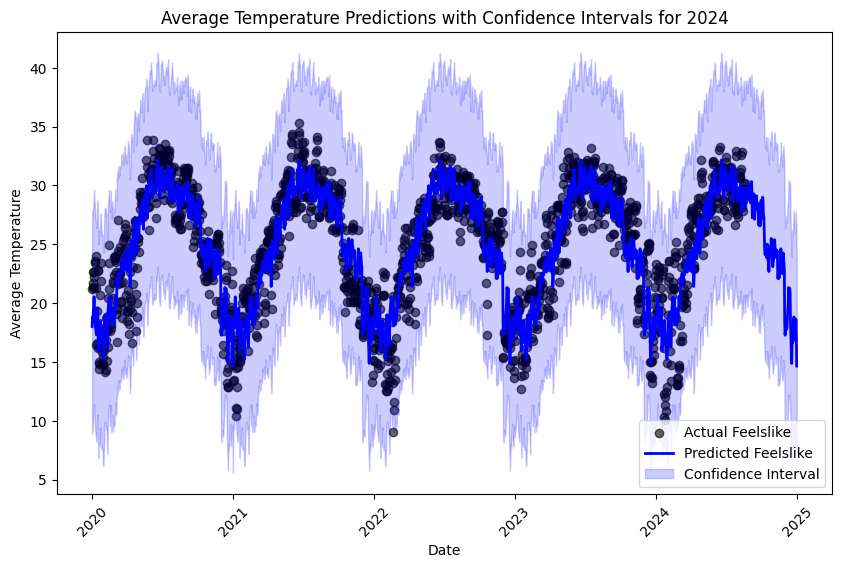

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../../../dataset/data.csv'  # Adjust the path to your dataset
data = pd.read_csv(file_path)

# Prepare the data for Polynomial Regression
X = data[['feelslike', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'dew', 'sealevelpressure', 'humidity', 'solarradiation', 'solarenergy']]
y = data['temp']

# Include the 'datetime' in the dataset
data['datetime'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')
data['day_of_year'] = data['datetime'].dt.dayofyear

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Apply Polynomial Features and Regularization (Ridge)
def create_model(degree, alpha):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    model = Ridge(alpha=alpha)
    model.fit(X_train_poly, y_train)
    return model, poly

# Hyperparameter tuning using manual grid search
param_grid = {
    'degree': [2, 3, 4, 5],  # Testing different polynomial degrees
    'alpha': [0.1, 1, 10]  # Different regularization strengths for Ridge
}

best_model = None
best_poly = None
best_score = float('-inf')

# Perform manual tuning for simplicity
for degree in param_grid['degree']:
    for alpha in param_grid['alpha']:
        model, poly = create_model(degree, alpha)
        X_test_poly = poly.transform(X_test)
        y_pred_test = model.predict(X_test_poly)
        score = r2_score(y_test, y_pred_test)
        
        if score > best_score:
            best_score = score
            best_model = model
            best_poly = poly

# Step 2: Evaluate the best model using test data
X_test_poly = best_poly.transform(X_test)
y_pred_test = best_model.predict(X_test_poly)

# Calculate R², RMSE, and MAE for the test set
r2 = r2_score(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

# Display the performance metrics
print(f"Best Degree: {best_poly.degree}")
print(f"Best Alpha (Regularization Strength): {best_model.alpha}")
print(f"R² Score (Test Set): {r2:.4f}")
print(f"RMSE (Test Set): {rmse:.4f}")
print(f"MAE (Test Set): {mae:.4f}")

# Step 3: Generate a date range from 21/08/2024 to 31/12/2024
future_dates = pd.date_range(start='2020-01-01', end='2024-12-31')
future_day_of_year = future_dates.dayofyear

# Step 4: Use historical averages for each day of the year to simulate future features
historical_averages = data.groupby('day_of_year')[['feelslike', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'dew', 'sealevelpressure', 'humidity', 'solarradiation', 'solarenergy']].mean()

# Create future features by using historical averages for the corresponding day of the year
future_features = pd.DataFrame({
    'feelslike': [historical_averages.loc[day, 'feelslike'] for day in future_day_of_year],
    'tempmax': [historical_averages.loc[day, 'tempmax'] for day in future_day_of_year],
    'tempmin': [historical_averages.loc[day, 'tempmin'] for day in future_day_of_year],
    'feelslikemax': [historical_averages.loc[day, 'feelslikemax'] for day in future_day_of_year],
    'feelslikemin': [historical_averages.loc[day, 'feelslikemin'] for day in future_day_of_year],
    'dew': [historical_averages.loc[day, 'dew'] for day in future_day_of_year],
    'sealevelpressure': [historical_averages.loc[day, 'sealevelpressure'] for day in future_day_of_year],
    'humidity': [historical_averages.loc[day, 'humidity'] for day in future_day_of_year],
    'solarradiation': [historical_averages.loc[day, 'solarradiation'] for day in future_day_of_year],
    'solarenergy': [historical_averages.loc[day, 'solarenergy'] for day in future_day_of_year]
})

# Step 5: Apply polynomial transformation on the future features using the best polynomial transformation
future_features_poly = best_poly.transform(future_features)

# Step 6: Predict the feelslike temperature for the future date range
temp_predictions = best_model.predict(future_features_poly)

# Step 7: Create a DataFrame to store the predictions
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Temperature': temp_predictions
})

# Calculate confidence intervals (simple +/- 1.96 * std deviation)
std_dev = np.std(temp_predictions)
lower_bound = temp_predictions - 1.96 * std_dev
upper_bound = temp_predictions + 1.96 * std_dev

# Add confidence intervals to the DataFrame
future_predictions_df['Lower Bound'] = lower_bound
future_predictions_df['Upper Bound'] = upper_bound

# Step 8: Save the predicted values to a CSV file
future_predictions_df.to_csv('finetuning.csv', index=False)
print("Predictions saved to 'finetuning.csv'")

# Step 9: Plot the predicted feelslike temperatures along with historical actual data

# Actual historical feelslike data (scatter plot)
plt.figure(figsize=(10, 6))
plt.scatter(data['datetime'], data['temp'], color='black', label='Actual Feelslike', alpha=0.6)

# Plot the predicted line
plt.plot(future_predictions_df['Date'], future_predictions_df['Predicted Feelslike'], label='Predicted Feelslike', color='blue', linewidth=2)

# Plot confidence intervals as a shaded area
plt.fill_between(future_predictions_df['Date'], future_predictions_df['Lower Bound'], future_predictions_df['Upper Bound'], color='blue', alpha=0.2, label='Confidence Interval')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Average Temperature Predictions with Confidence Intervals for 2024')
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.show()
